In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

from numerics import calc_error_probabilities
import itertools

In [4]:
# Calculate the CDF across a few values of gamma and sigma, as well as fixed T, and T scaling with n
sigma = [1, 10]
gamma = [1, 0.1]
n = [100, 200, 500, 1000]

In [6]:
# case 1: No scaling
T = 100
S = 50
npenalties = 25

combinations = list(itertools.product(sigma, gamma, n))
actual_probs = np.zeros((len(combinations), npenalties))
chernoff_probs = np.zeros((len(combinations), npenalties))

In [59]:
for i, combo in enumerate(combinations):

    sigma_, gamma_, n_ = combo
    penalties = np.linspace(0, 2 * np.log(n_), npenalties)
    t0 = time.time()
    for j, penalty in enumerate(penalties):
        Delta = sigma_**2 * penalty * (T - S)
        Delta0 = sigma_**2 * penalty * (S - T)
        mu = sigma_**2 * T - gamma_**2 * (n_ - T)
        p1, p2 = calc_error_probabilities(n_, sigma_, T, gamma_, Delta - mu, Delta0)
        actual_probs[i, j] = p1
        chernoff_probs[i, j]= p2
    print(time.time() - t0)    

19.954583883285522
22.906044721603394
34.31839728355408
43.23118305206299
18.95184564590454
30.876556873321533
47.86816692352295
57.72919940948486
20.30770707130432
32.13776874542236
49.09903931617737
56.59222388267517
18.877305269241333
31.138213634490967
47.08513903617859
55.75535225868225


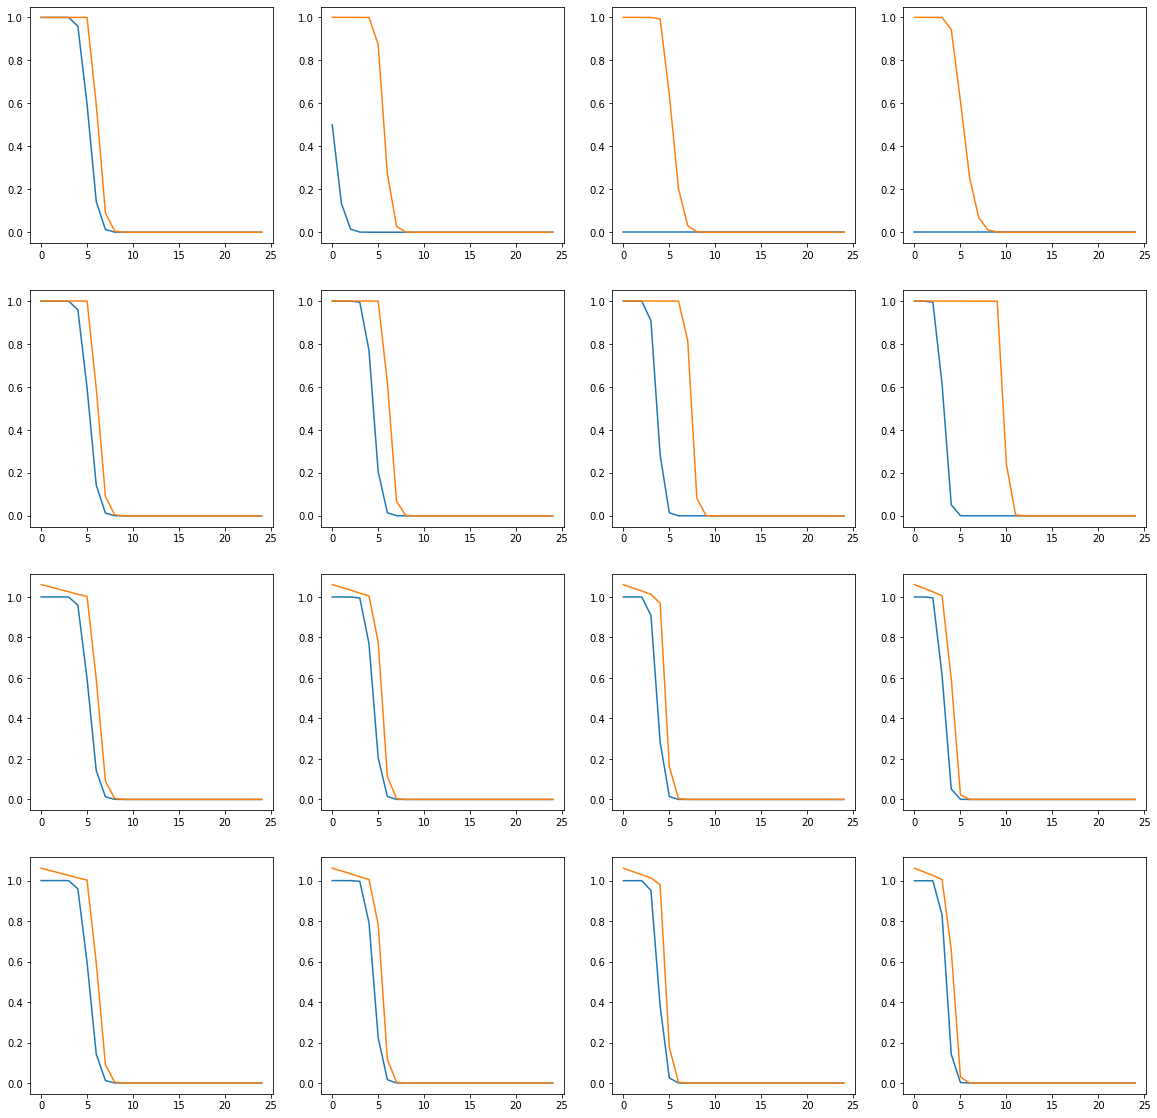

In [61]:
# Determine how closesly the bounds track the real CDF

# For a fixed n, T, sigma, and gamma, we can plot as a function of the penalty
fig, ax = plt.subplots(4, 4, figsize = (20, 20))
for i, combo in enumerate(combinations):
        a = ax[np.unravel_index(i, (4, 4))]
        a.plot(actual_probs[i, :])
        a.plot(np.exp(chernoff_probs[i, :]))

In [17]:
from numerics import chernoff_bound

In [18]:
import scipy

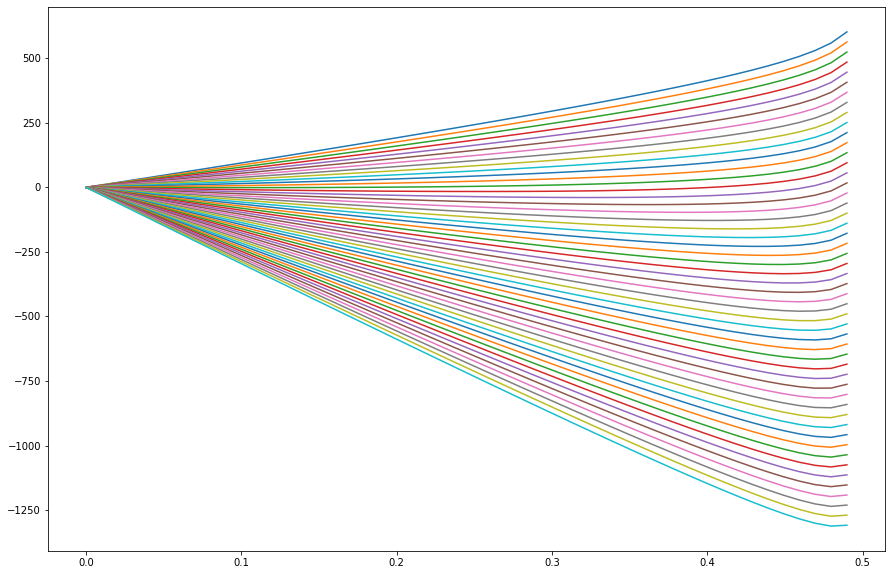

In [46]:
# Track the t and the minimum for the chernoff bound as we increase Delta. Is it simply necessary to scale
# n to a reasonable amount? The chernoff bound should give 1 if possible

n = 5000
T = 100
sigma = 1
gamma = 0.1

mu = sigma * T - (n - T) * gamma 

ndelta = 50

tstar = np.zeros(ndelta)
pstar = np.zeros(ndelta)

fig, ax = plt.subplots(figsize=(15, 10))
bounds = (0, 1/(2 * sigma**2))

for i, Delta in enumerate(np.linspace(0, np.abs(10 * mu), ndelta)):
    result = scipy.optimize.minimize_scalar(chernoff_bound, args = (n, sigma, T, gamma, Delta), bounds=bounds,
                                           method='Bounded')
    t = np.linspace(0, 1/(2 * sigma**2))
    plt.plot(t, [chernoff_bound(tt, n, sigma, T, gamma, Delta) for tt in t])
    tstar[i] = result.x
    pstar[i] = result.fun

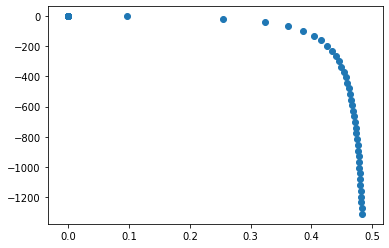

In [47]:
plt.scatter(tstar, pstar)

In [63]:
import pickle

In [64]:
with open('numerical_results2.dat', 'rb') as f:
    results = pickle.load(f)

In [65]:
import pandas as pd

In [67]:
# Create a dataframe
result_dicts = []
for result in results:
    
    sigma = result[1][0]
    gamma = result[1][1]
    p = result[1][2]
    n = p
    S = np.arange(10, p/2, 50, dtype=int)
    penalties = np.linspace(0, 2 * np.log(n), 25)
    for i, S_ in enumerate(S):
        result_dict = {}
        result_dict['sigma'] = sigma
        result_dict['gamma'] = gamma
        result_dict['p'] = p
        result_dict['S_'] = S_
        result_dict['penalties'] = penalties
        result_dict['error_prob'] = result[0][i, :]
        
        result_dicts.append(result_dict)

In [68]:
df = pd.DataFrame(result_dicts)

In [71]:
import sys
sys.path.append('..')
from postprocess_utils import apply_df_filters

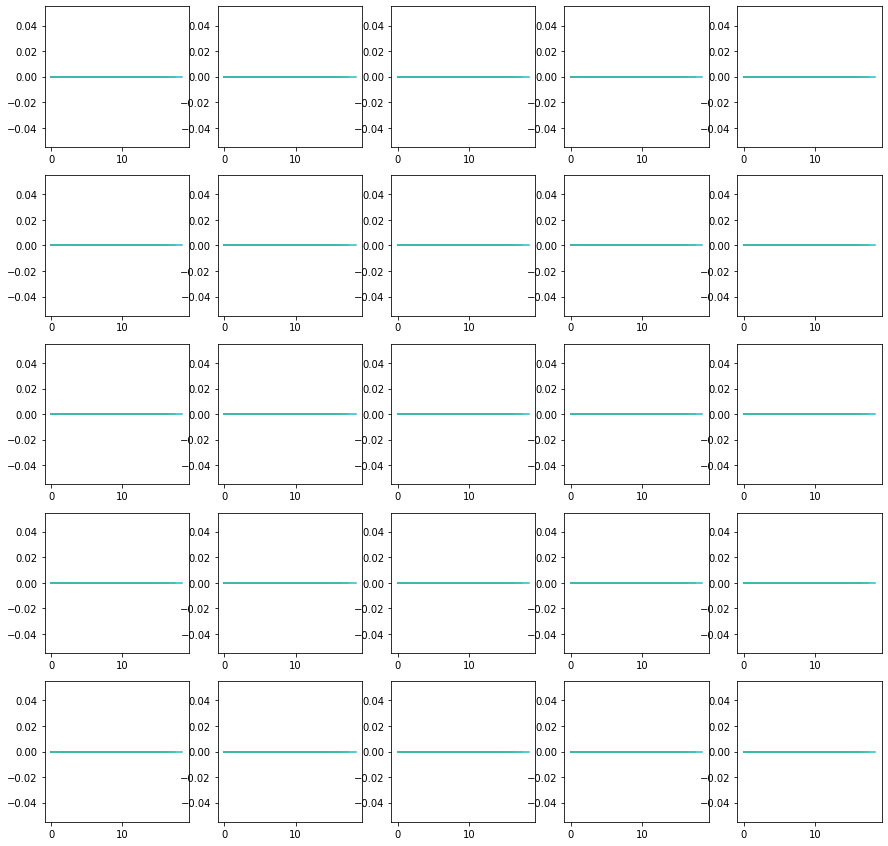

In [79]:
# For each gamma, sigma combination, plot the error probability as a function of penalty for a series of S
# values that correspond most closely to log(p) for each p
sigma = np.unique(df['sigma'].values)
gamma = np.unique(df['gamma'].values)

fig, ax = plt.subplots(sigma.size, gamma.size, figsize = (15, 15))

for i, s in enumerate(sigma):
    for j, g in enumerate(gamma):
        
        a = ax[i, j]
        df_ = apply_df_filters(df, sigma = s, gamma = g)
        
        p = np.unique(df_['p'].values)
        S = np.unique(df_['S_'].values)
        for k, p_ in enumerate(p):
            # Find the S that most closely corresponds to log(p)
            target_S = min(S)
            S_ = S[(np.abs(S - target_S)).argmin()]
            df_S = apply_df_filters(df_, S_ = S_, p = p_)
            assert(df_S.shape[0] == 1)
            
            a.plot(df_S.iloc[0]['penalties'], df_S.iloc[0]['error_prob'])
        